###Step 1:  Exploratory Data Analysis

In [17]:
# import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Load the dataset
data = pd.read_csv('train.csv')
print("Rows in train.csv = ", data.shape[0])
print("Columns in train.csv = ", data.shape[1])

data.head()

Rows in train.csv =  159571
Columns in train.csv =  8


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [20]:
# checking the presence of any null value in the data set
data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

* No null comments to be found

In [21]:
# Calculating the total count of each category comments

#dropping id and comment_text columns
data_category_count = data.drop(['id', 'comment_text'], axis=1)

counts = []
categories = list(data_category_count.columns.values)
print(categories)
for i in categories:
  counts.append((i, data_category_count[i].sum()))
df_stats = pd.DataFrame(counts, columns =['category', 'count'])
df_stats

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


,category,count
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


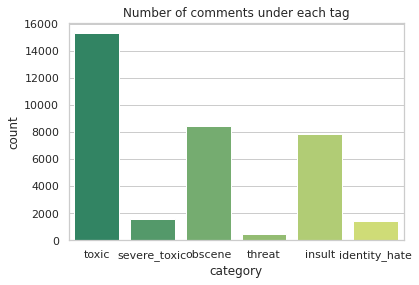

In [22]:
# The categorywise bar plot
sns.set(style="whitegrid")
sns.barplot(x='category', y='count', data= df_stats, palette="summer")
plt.title("Number of comments under each tag")
plt.show()

* This shows that the number of comments in each category is **extremely unbalanced.**

* Next we check whether each comment has been tagged or not ?

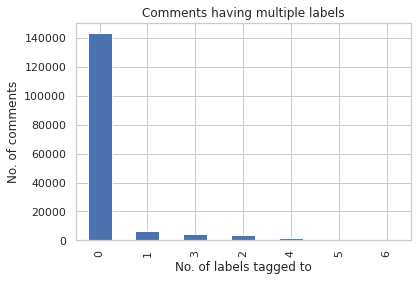

89.83211235124176 % comments have no labels associated to them.


In [23]:
# Counting the number of comments having multiple labels
rowsums = data_category_count.iloc[:,:].sum(axis=1)
valcount = rowsums.value_counts()
valcount.plot.bar()
plt.xlabel("No. of labels tagged to")
plt.ylabel("No. of comments")
plt.title("Comments having multiple labels")
plt.show()

print(valcount[0]*100/sum(valcount), "% comments have no labels associated to them.")

* This shows that a large amount of entire dataset is tagged to none of the six labels.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


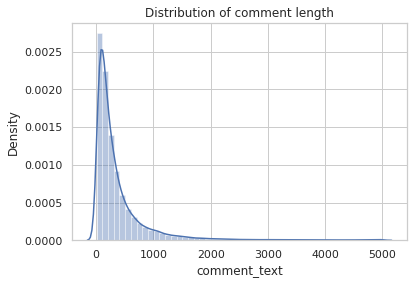

In [24]:
length = data.comment_text.str.len()
sns.distplot(length)
plt.title("Distribution of comment length")
plt.show()

* We find that most of the comments are of length less than 500, while a few reach the length of 5000 as well.

* WordCloud representation of most used words in each category of comments.

In [25]:
# from wordcloud import WordCloud,STOPWORDS
# plt.figure(figsize=(40,25))
# # clean
# subset = data[data.clear==True]
# text = subset.comment_text.values
# cloud_toxic = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='black',
#                           collocations=False,
#                           width=2500,
#                           height=1800
#                          ).generate(" ".join(text))
# plt.axis('off')
# plt.title("Clean",fontsize=40)
# plt.imshow(cloud_clean)

###Step 2:  Data Preprocessing

* Clean the text, convert weren't to were not and so on..

* Checking correlation between various label properties

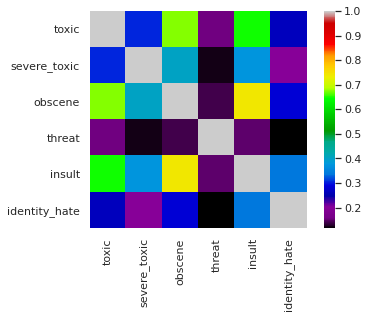

In [26]:
sns.heatmap(data.corr(), square=True, cmap='nipy_spectral')
plt.show()

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
df = data
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
df['comment_text'] = df['comment_text'].str.lower()
df['comment_text'] = df['comment_text'].apply(cleanHtml)
df['comment_text'] = df['comment_text'].apply(cleanPunc)
df['comment_text'] = df['comment_text'].apply(keepAlpha)

* Removing stopwords

In [28]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
df['comment_text'] = df['comment_text'].apply(removeStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* Next we do stemming

This is basically transforming words with roughly the same semantics to one standard form.
Ex. - amusing, amusement to a stem amus

In [29]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
df['comment_text'] = df['comment_text'].apply(stemming)

* The TF-IDF Vectorizer

In [30]:
# from sklearn.model_selection import train_test_split
# train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
# vectorizer.fit(train)
# vectorizer.fit(test)
# x_train = vectorizer.transform(train)
# y_train = train.drop(labels = ['id','comment_text'], axis=1)
# x_test = vectorizer.transform(test)
# y_test = test.drop(labels = ['id','comment_text'], axis=1)

###Step 3:  Multi-Label Classification Techniques

In [31]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [34]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

In [35]:
train.shape, test.shape

((106912, 8), (52659, 8))

In [36]:
X_train = train['comment_text']
X_test = test['comment_text']

### Machine Learning Pipeline

In [37]:
accuracies = [[],[],[]]

### 1. Multinomial Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cvec = CountVectorizer()
tvec = TfidfTransformer()
model1 = MultinomialNB()

In [39]:
X_train = tvec.fit_transform(cvec.fit_transform(X_train))
X_test = tvec.transform(cvec.transform(X_test))

In [40]:
X_train.shape, X_test.shape

((106912, 107032), (52659, 107032))

In [41]:
for category in labels:
    model1.fit(X_train, train[category])
    accuracy = model1.score(X_test, test[category])
    accuracies[0].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))

Accuracy For toxic Class Is 92.09%
Accuracy For severe_toxic Class Is 99.0%
Accuracy For obscene Class Is 95.17%
Accuracy For threat Class Is 99.71%
Accuracy For insult Class Is 95.2%
Accuracy For identity_hate Class Is 99.11%


###2. Linear Support Vector Classifier

In [42]:
from sklearn.svm import LinearSVC
model2 = LinearSVC()
for category in labels:
    model2.fit(X_train, train[category])
    accuracy = model2.score(X_test, test[category])
    accuracies[1].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))


Accuracy For toxic Class Is 96.04%
Accuracy For severe_toxic Class Is 99.06%
Accuracy For obscene Class Is 97.9%
Accuracy For threat Class Is 99.75%
Accuracy For insult Class Is 97.09%
Accuracy For identity_hate Class Is 99.23%


### 3. Logistic Regression Classifier

In [43]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression(n_jobs=1, solver='liblinear')
for category in labels:
    model3.fit(X_train, train[category])
    accuracy = model3.score(X_test, test[category])
    accuracies[2].append(accuracy)
    print("Accuracy For {0} Class Is {1}%".format(category,round(accuracy*100,2)))


Accuracy For toxic Class Is 95.6%
Accuracy For severe_toxic Class Is 99.08%
Accuracy For obscene Class Is 97.72%
Accuracy For threat Class Is 99.74%
Accuracy For insult Class Is 97.0%
Accuracy For identity_hate Class Is 99.19%


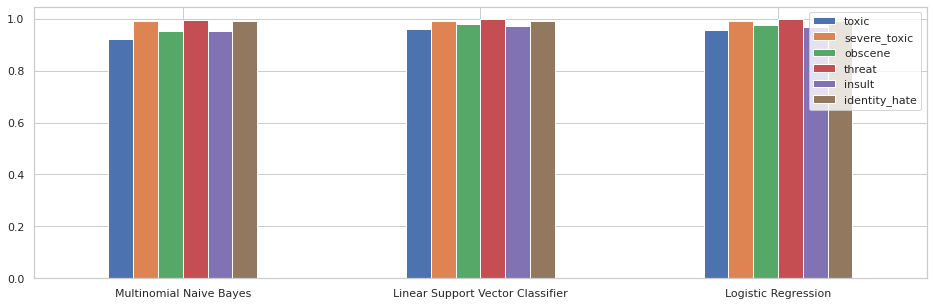

In [44]:
# Plotting accuracies of different classifiers
import numpy as np

accuracies = pd.DataFrame(accuracies)
fig = accuracies.plot.bar(figsize=(16, 5), grid=True)
plt.xticks(np.arange(3),('Multinomial Naive Bayes','Linear Support Vector Classifier','Logistic Regression'),rotation=0)
plt.legend(labels)
plt.show()

In [45]:
for i in range(3):
    print("Model -",i+1,"-> Aggregate Accuracy ->",np.mean(accuracies.iloc[i,:]))

Model - 1 -> Aggregate Accuracy -> 0.9671281262462257
Model - 2 -> Aggregate Accuracy -> 0.9818043132861113
Model - 3 -> Aggregate Accuracy -> 0.9805604613329789


* We find that out of the 3 models **Linear SVC** proves  to be the best.

###Step 4:  Multi-Label Classification Techniques

* Model Chosen = Linear SVC

* Vectoriser = TFIDF + CountVectorizer

In [48]:
X_test = pd.read_csv('test.csv')
y_test = pd.read_csv('test_labels.csv')
sample = pd.read_csv('sample_submission.csv')

In [49]:
print("Total training data points:",len(train))
print("Total testing data points:",len(X_test))

Total training data points: 106912
Total testing data points: 153164


In [50]:
X_train_vec = tvec.fit_transform(cvec.fit_transform(train['comment_text']))
X_test_vec = tvec.transform(cvec.transform(X_test['comment_text']))

In [51]:
from sklearn.svm import LinearSVC
final_model = LinearSVC()
predictions = []
accuracy_list=[]
for cat in labels:
    final_model.fit(X_train_vec, train[cat]) #fitting the model
    y_pred = final_model.predict(X_test_vec).tolist() #np array of predictions to list
    accuracy = final_model.score(X_test_vec, y_test[cat])
    predictions.append(y_pred)
    accuracy_list.append(accuracy)
    print("Class",cat,"-> Accuracy score = ",accuracy)

Class toxic -> Accuracy score =  0.38904703455120004
Class severe_toxic -> Accuracy score =  0.41516936094643647
Class obscene -> Accuracy score =  0.4009623671358805
Class threat -> Accuracy score =  0.41634457183150086
Class insult -> Accuracy score =  0.399186492909561
Class identity_hate -> Accuracy score =  0.4134130735682014


In [52]:
print("Average Accuracy:",np.mean(accuracy_list))

Average Accuracy: 0.40568715015713


In [53]:
sample.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [54]:
test_result = pd.DataFrame({'id':X_test['id'],'toxic':predictions[0],'severe_toxic':predictions[1],'obscene':predictions[2],'threat':predictions[3],'insult':predictions[4],'identity_hate':predictions[5]})

In [55]:
test_result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,0,1,0,0,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [56]:
# Export to csv
test_result.to_csv('submit.csv')

* Saving the final model in pickle file

In [57]:
import pickle

In [58]:
pickle.dump(final_model, open('Final_Model.pkl', 'wb'))